# Predicting Star Ratings Based on Amazon Review Comments of Digital Music Albums

For this project, I will be analyzing Amazon user reviews of digital music. My goal is to predict the star-rating a user will give a product based on the review comment they give. Since the star rating prediction is only based on a text review, it serves as a proxy for building a sentiment classifier – assuming that star rating is truly representative of a review’s sentiment.

## Data Loading and Preliminary Exploration

Import libraries for data processing

In [1]:
import os #used to manage directories
import json #for reading JSON file
import pandas as pd # for data cleaning
import nltk #used for text preprocessing
import numpy as np #for data scrubbing


To minimize the time spent on training, I only sampled a subset of the raw dataframe. I chose to sample 10,000 records, but this can be changed with the parameter below

In [2]:
sample_size = 10000

Set my folder directory path.

In [3]:
# source data from http://jmcauley.ucsd.edu/data/amazon/
os.chdir('C:\My_Files\Analytics\Amazon_reviews\Digital_Music.json')
os.getcwd()

'C:\\My_Files\\Analytics\\Amazon_reviews\\Digital_Music.json'

Load in the JSON file, and print a few sample rows.

In [4]:
data = [json.loads(f) for f in open("Digital_Music.json", 'r')]
type(data) #view data type
data[1:3] #view sample of data

[{'overall': 5.0,
  'verified': True,
  'reviewTime': '09 11, 2013',
  'reviewerID': 'AC2PL52NKPL29',
  'asin': '0001388703',
  'style': {'Format:': ' Audio CD'},
  'reviewerName': 'Norma Mushen',
  'reviewText': 'So creative!  Love his music - the words, the message! Some of my favorite songs on this CD. I should have bought it years ago!',
  'summary': 'Gotta listen to this!',
  'unixReviewTime': 1378857600},
 {'overall': 5.0,
  'verified': True,
  'reviewTime': '03 2, 2013',
  'reviewerID': 'A1SUZXBDZSDQ3A',
  'asin': '0001388703',
  'style': {'Format:': ' Audio CD'},
  'reviewerName': 'Herbert W. Shurley',
  'reviewText': 'Keith Green, gone far to early in his carreer, left us with these few golden alblums to bless us and let us see from a more in sync world veiw or I should say "the language of the modern world\'.\n\nHad this on LP all His alblums..look for ammples and then you will wee what I am talking about.\nGod Bless you all',
  'summary': 'Great approach still gets the messa

Next, I converted the data into a dataframe. Then I printed the dimensions of dataframe, and the distribution of star rating proportions. As seen below, there are ~1.6 Million user review records, and ~80% have a 5-star rating

In [5]:
df = pd.DataFrame(data) #convert to dataframe

print(df.shape)
df.overall.value_counts(normalize = True)

(1584082, 12)


5.0    0.808132
4.0    0.113586
3.0    0.036202
1.0    0.027213
2.0    0.014867
Name: overall, dtype: float64

Since such a high proportion of records have a 5-star rating, I was concerned that it would be hard to interpret the true predictive power of the model based on accuracy in prediction. To slightly mitigate this, I resammpled the dataframe so that a higher proportion of records with star-ratings < 5 were sampled.

For sampling, I assigned higher weights to records that had star ratings < 5

In [6]:
df['Weights'] = np.where(df['overall'] < 5, .75, .25)
df['Weights'].unique()



array([0.25, 0.75])

When sampling based on these weights, the distribution of star ratings become more normalized (~60% with a 5-star rating). 
To minimize time spent on training, I only sampled 10,000 rows. I also made sure to drop any records from the Review and Ratings column that had NA values. 

In [7]:
sample = df.sample(n = sample_size, random_state = 10, weights = 'Weights') #create dataframe of 10,000 sample records

sample = sample.dropna(how = 'any', subset = ['reviewText', 'overall'])

In [8]:
###check distribution of star ratings in sample
sample.overall.value_counts(normalize = True)

5.0    0.587670
4.0    0.245396
3.0    0.074660
1.0    0.061249
2.0    0.031025
Name: overall, dtype: float64

Below is a snapshot of the top 5 records in the sampled dataframe

In [9]:
sample.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Weights
1211981,4.0,True,"04 1, 2013",A3I4GB927A6JPA,B00BZOG5JU,{'Format:': ' MP3 Music'},Umberto Borgia,Fans of Donaggio's previous De Palma scores wi...,Donaggio in fine form,1364774400,4,NaN,0.75
32461,5.0,False,"12 7, 2012",A1OQ66R7ZI2GEW,B000W1774O,{'Format:': ' MP3 Music'},gailbop,This is a good song. Johnny Cash at his best. ...,Hurt,1354838400,NaN,NaN,0.25
997656,1.0,False,"03 19, 2011",A1M2KVPOO9JCZH,B004B6HKSE,NaN,Bacchus,I bought this CD thinking the musician was the...,"Not the ""Real"" Eric Andersen",1300492800,NaN,NaN,0.75
1176672,5.0,True,"12 29, 2015",A3HU7471MKOCDR,B00AGBBBL0,{'Format:': ' MP3 Music'},nick,Great song many don't know about,Five Stars,1451347200,NaN,NaN,0.25
785697,1.0,True,"12 14, 2015",A12RD6KVJG5ZK1,B00137Y19U,{'Format:': ' MP3 Music'},Muncie_Birder,I could not get more than half way through rea...,... could not get more than half way through r...,1450051200,NaN,NaN,0.75


## Text Preprocessing

First, I wanted to check the datatypes of each variable in my sampled dataframe

In [10]:
sample.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
image              object
Weights           float64
dtype: object

I converted the star rating column from integer to string so that it could properly feed into subsequent modeling

In [11]:
sample['overall'] = sample['overall'].astype(str)

My next step was to tokenize the words in each record's review text

In [12]:
from nltk import word_tokenize

tokens = [word_tokenize(sen) for sen in sample.reviewText]
# sample['raw_tokens'] = tokens

Then I removed all stop words from the tokenized word list, like "this" and "it's"

In [13]:
from nltk.corpus import stopwords

stoplist = stopwords.words('english')

def removeStopWords(tokens):
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in tokens]

sample['raw_tokens'] = filtered_words #join to dataframe

# sample['Text_Final'] = [' '.join(sen) for sen in filtered_words]
# sample['tokens'] = filtered_words

A snapshot of tokens with removed stop words is seen in the raw_tokens column below.

In [14]:
sample.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Weights,raw_tokens
1211981,4.0,True,"04 1, 2013",A3I4GB927A6JPA,B00BZOG5JU,{'Format:': ' MP3 Music'},Umberto Borgia,Fans of Donaggio's previous De Palma scores wi...,Donaggio in fine form,1364774400,4,NaN,0.75,"[Fans, Donaggio, 's, previous, De, Palma, scor..."
32461,5.0,False,"12 7, 2012",A1OQ66R7ZI2GEW,B000W1774O,{'Format:': ' MP3 Music'},gailbop,This is a good song. Johnny Cash at his best. ...,Hurt,1354838400,NaN,NaN,0.25,"[This, good, song, ., Johnny, Cash, best, ., I..."
997656,1.0,False,"03 19, 2011",A1M2KVPOO9JCZH,B004B6HKSE,NaN,Bacchus,I bought this CD thinking the musician was the...,"Not the ""Real"" Eric Andersen",1300492800,NaN,NaN,0.75,"[I, bought, CD, thinking, musician, wonderful,..."
1176672,5.0,True,"12 29, 2015",A3HU7471MKOCDR,B00AGBBBL0,{'Format:': ' MP3 Music'},nick,Great song many don't know about,Five Stars,1451347200,NaN,NaN,0.25,"[Great, song, many, n't, know]"
785697,1.0,True,"12 14, 2015",A12RD6KVJG5ZK1,B00137Y19U,{'Format:': ' MP3 Music'},Muncie_Birder,I could not get more than half way through rea...,... could not get more than half way through r...,1450051200,NaN,NaN,0.75,"[I, could, get, half, way, really, boring, boo..."


Then I further normalized the data by removing non_ascii words, making everything lowercase, removing punctuation marks, and replacing numbers with words. This is accomplished by the series of functions below.
Some code snippets were pulled from https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html

In [15]:

import re, string, unicodedata
# import contractions
import inflect
from nltk.corpus import stopwords

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
    

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

#remove all punctuation
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words


def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words


The functions were applied to each record in the sampled dataframe. The updated normalized tokens are seen in the tokens column below.

In [16]:
sample['tokens'] = sample['raw_tokens'].apply(lambda x: normalize(x))
sample.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Weights,raw_tokens,tokens
1211981,4.0,True,"04 1, 2013",A3I4GB927A6JPA,B00BZOG5JU,{'Format:': ' MP3 Music'},Umberto Borgia,Fans of Donaggio's previous De Palma scores wi...,Donaggio in fine form,1364774400,4,NaN,0.75,"[Fans, Donaggio, 's, previous, De, Palma, scor...","[fans, donaggio, s, previous, de, palma, score..."
32461,5.0,False,"12 7, 2012",A1OQ66R7ZI2GEW,B000W1774O,{'Format:': ' MP3 Music'},gailbop,This is a good song. Johnny Cash at his best. ...,Hurt,1354838400,NaN,NaN,0.25,"[This, good, song, ., Johnny, Cash, best, ., I...","[this, good, song, johnny, cash, best, it, plu..."
997656,1.0,False,"03 19, 2011",A1M2KVPOO9JCZH,B004B6HKSE,NaN,Bacchus,I bought this CD thinking the musician was the...,"Not the ""Real"" Eric Andersen",1300492800,NaN,NaN,0.75,"[I, bought, CD, thinking, musician, wonderful,...","[i, bought, cd, thinking, musician, wonderful,..."
1176672,5.0,True,"12 29, 2015",A3HU7471MKOCDR,B00AGBBBL0,{'Format:': ' MP3 Music'},nick,Great song many don't know about,Five Stars,1451347200,NaN,NaN,0.25,"[Great, song, many, n't, know]","[great, song, many, nt, know]"
785697,1.0,True,"12 14, 2015",A12RD6KVJG5ZK1,B00137Y19U,{'Format:': ' MP3 Music'},Muncie_Birder,I could not get more than half way through rea...,... could not get more than half way through r...,1450051200,NaN,NaN,0.75,"[I, could, get, half, way, really, boring, boo...","[i, could, get, half, way, really, boring, boo..."


Lastly, I performed stemming on each of the token words. I chose to use Lemmatization, which is a type of stemming technique. These were applied to the same tokens column above.

In [17]:
from nltk.stem import LancasterStemmer, WordNetLemmatizer

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [18]:
sample['tokens'] = sample['tokens'].apply(lambda x: lemmatize_verbs(x))

The next few cells below show the progession of the tokenization and preprocessing for a sample review.

The raw text is shown below.

In [19]:
sample['reviewText'][349813]

"I listened to the song on YouTube and thought I'd buy the song as it's a very catchy tune.  From 2:13 - 2:32 in the song, there is a terrible mix job cutting the Nelly part in, some of the words are different and it doesn't flow with the song very well.  You can actually hear the cut with the mix and it just sound strange and does not flow well with the rest of the song.  Save your money and listen to the one on YouTube."

The tokenized version with removed stopwords is below.

In [20]:
print(sample['raw_tokens'][349813])

['I', 'listened', 'song', 'YouTube', 'thought', 'I', "'d", 'buy', 'song', "'s", 'catchy', 'tune', '.', 'From', '2:13', '-', '2:32', 'song', ',', 'terrible', 'mix', 'job', 'cutting', 'Nelly', 'part', ',', 'words', 'different', "n't", 'flow', 'song', 'well', '.', 'You', 'actually', 'hear', 'cut', 'mix', 'sound', 'strange', 'flow', 'well', 'rest', 'song', '.', 'Save', 'money', 'listen', 'one', 'YouTube', '.']


And the tokens with complete normalization is shown below.

In [21]:
print(sample['tokens'][349813])

['i', 'listen', 'song', 'youtube', 'think', 'i', 'd', 'buy', 'song', 's', 'catchy', 'tune', 'from', 'two hundred and thirteen', 'two hundred and thirty-two', 'song', 'terrible', 'mix', 'job', 'cut', 'nelly', 'part', 'word', 'different', 'nt', 'flow', 'song', 'well', 'you', 'actually', 'hear', 'cut', 'mix', 'sound', 'strange', 'flow', 'well', 'rest', 'song', 'save', 'money', 'listen', 'one', 'youtube']


In [22]:
freq_words = sample.tokens.str.split(expand = True).stack().value_counts()
freq_words

Series([], dtype: int64)

### Word Clouds for Distribution of Words

I was curious how the distribution of words varied for reviews with different star ratings. As a way to visualize this, I created word clouds of the reviews for each star rating 1-5. To supplement this, I also calcuated the top 10 most frequent words and counts for each star rating.

The function below filters the sampled dataframe on a designated star-rating (e.g. '1.0'). Then, a list is created that joins all normalized tokens across all records into a list.

In [23]:
def text_per_rating(rating):
    sample_rating = sample[sample['overall'] == rating]
    text_list = sample_rating['tokens'].tolist() #convert review text to list of tokens
    text_list = list([a for b in text_list for a in b]) #merge across records into a single list
    # text_list[0:50]
    text_list = ' '.join(map(str, text_list)) #remove commas and create list of all words in dataset separated by space
    # concat_text = text_list.str.cat(sep =', ')
    # text_list[0:100]
    return text_list

From this list, the function below counts the frequency of the top 10 words per designated star rating.

In [24]:
from collections import Counter

def freq(rating):
    str_list = text_per_rating(rating)
    str_list = str_list.split()
#     unique_words = set(str_list)
    counts = Counter(str_list)
    counts = counts.most_common(10)
    return counts

A word cloud is also created for each star rating. In the word cloud, I had the option to ignore a custom list of words. I chose exclude words like "album" and "song" from the word cloud because I expected they would be very frequent, but not provide much insight into the sentiment of the reviews per star rating. Code was referenced from https://www.datacamp.com/community/tutorials/wordcloud-python

In [25]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

def plot_word_clouds(rating):
    text_list = text_per_rating(rating)
    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["album", "song", "cd", "music", "songs"])

    # text_cloud = sample.reviewText
    text_cloud = str(text_list)
    wordcloud = WordCloud(stopwords = stopwords, background_color = "white").generate(text_cloud)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title('Word cloud for {} star rating'.format(rating))
    plt.axis("off")
    plt.show()

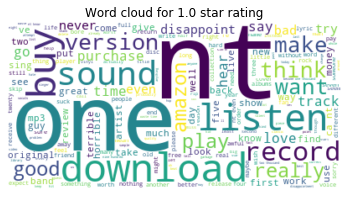

In [26]:
plot_word_clouds('1.0')

In [27]:
freq('1.0')

[('i', 815),
 ('nt', 247),
 ('song', 234),
 ('s', 214),
 ('this', 143),
 ('one', 142),
 ('like', 136),
 ('cd', 132),
 ('the', 132),
 ('it', 130)]

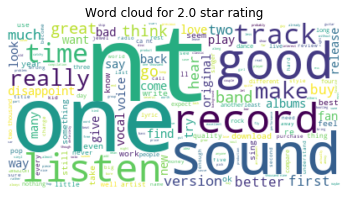

In [28]:
plot_word_clouds('2.0')

In [29]:
freq('2.0')

[('i', 527),
 ('s', 196),
 ('nt', 164),
 ('album', 149),
 ('the', 146),
 ('like', 130),
 ('song', 113),
 ('one', 113),
 ('sound', 112),
 ('songs', 101)]

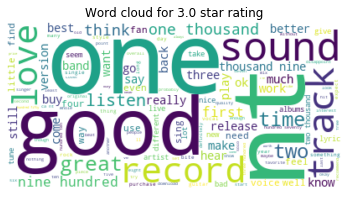

In [30]:
plot_word_clouds('3.0')

In [31]:
freq('3.0')

[('i', 1209),
 ('s', 585),
 ('one', 373),
 ('the', 365),
 ('nt', 348),
 ('and', 330),
 ('song', 323),
 ('album', 305),
 ('like', 293),
 ('hundred', 249)]

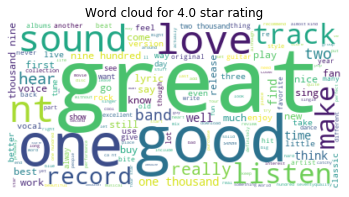

In [32]:
plot_word_clouds('4.0')

In [33]:
freq('4.0')

[('i', 2947),
 ('s', 1567),
 ('song', 1246),
 ('the', 1201),
 ('one', 1019),
 ('album', 955),
 ('like', 884),
 ('good', 820),
 ('great', 755),
 ('music', 752)]

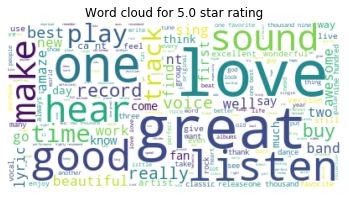

In [34]:
plot_word_clouds('5.0')

In [35]:
freq('5.0')

[('i', 5347),
 ('song', 2641),
 ('love', 2191),
 ('s', 1920),
 ('great', 1736),
 ('music', 1497),
 ('one', 1420),
 ('album', 1387),
 ('the', 1341),
 ('this', 1220)]

As seen from the word clouds and frequencies above, there is a very similar distribution of common words across all star ratings. Even among 1 star ratings, words like "good", "great", and "love" were still very common. However, it's possible these sentiments were negated with preceeding words like 'not good'.

## Predictive Models for Star Rating

### Bag of Words Method

With the BOW method, a matrix of vectors is created that represents the frequency of each word. Each vector corresponds to a review, and the width of each vector is the number of all distinct words in the entire corpus across all records. 

#### Testing on SVM Model

Split training and test data

In [36]:
print(sample['tokens'][1506350])

['i', 'ca', 'nt', 'say', 'i', 'hate', 'song', 'little', 'evil', 'go', 'decency', 'i', 'would', 'nt', 'recommend', 'anyone', 'nt', 'practice', 'witch', 'craft']


In [37]:
from sklearn.model_selection import train_test_split

# sentences = sample['tokens'].values
sentences = sample['tokens'].str.join(' ') ## join values into string
y = sample['overall'].values
# y = dummy_y

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

In [38]:
sentences_train[1506350]

'i ca nt say i hate song little evil go decency i would nt recommend anyone nt practice witch craft'

Vectorize the training and test data

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)



Train the model

In [40]:
from sklearn.svm import SVC

from datetime import datetime
start_time = datetime.now()

classifier_svc = SVC()
classifier_svc.fit(X_train, y_train)
score = classifier_svc.score(X_test, y_test)
score_train = classifier_svc.score(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train

Duration: 0:00:17.440701


Below, I explored the use of Pickle, which is used for saving trained models as objects that can be loaded at a later time. For some reason, the accuracy of my models drastically fluctuated when reloading the saved pickle objects.

Accuracy of the SVM model is printed below.

In [41]:
print("Training Accuracy:", score_train) #print accuracy of SVM model
print("Testing Accuracy:", score) #print accuracy of SVM model

from sklearn.externals import joblib
import pickle

os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')


joblib.dump(classifier_svc, "classifier_svc.pkl")

Training Accuracy: 0.6910862022951695
Testing Accuracy: 0.6176941553242594


C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['classifier_svc.pkl']

In [42]:
from sklearn.externals import joblib
import pickle

os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')
classifier_svc = joblib.load("classifier_svc.pkl")

score = classifier_svc.score(X_test, y_test)
print("Accuracy:", score) #print accuracy of SVM model

Accuracy: 0.6176941553242594


The confusion matrix plot is below. Note that very few predictions were made that were not 5-stars. This same output was done for all subsequent models.

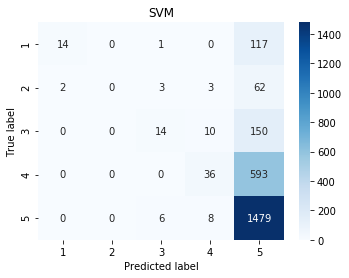

Accuracy: 0.6176941553242594


In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)
predictions = classifier_svc.predict(X_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test, predictions) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("SVM")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

# loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))
score = classifier_svc.score(X_test, y_test)
print("Accuracy:", score) #print accuracy of SVM model

In [44]:
from keras import backend as K

def recall_m(y_test, predictions):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predictions, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, predictions):
    precision = precision_m(y_test, predictions)
    recall = recall_m(y_test, predictions)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


The output below shows additional performance metrics for my SVM model. As seen, the F1 score is fairly low, which measures the balance of precision and recall. This same output was done for all subsequent models.

In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.88      0.11      0.19       132
         2.0       0.00      0.00      0.00        70
         3.0       0.58      0.08      0.14       174
         4.0       0.63      0.06      0.10       629
         5.0       0.62      0.99      0.76      1493

    accuracy                           0.62      2498
   macro avg       0.54      0.25      0.24      2498
weighted avg       0.61      0.62      0.50      2498



C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
pred_stars = predictions.tolist()
# pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

['5.0', '5.0', '5.0', '5.0']

In [47]:
test_indexes = sentences_test.index
# sample.iloc[test_indexes]
# sample.iloc[[5441],:]

A key performance metric I wanted to evaluate was how close my star rating predictions were to the actual rating. The dataframe below captures the absolute difference between the actual and predicted rating in the "diff_pred" column. This dataframe snapshot is of the records with the biggest difference between prediction and rating (the worst performers). This same output was done for all subsequent models.

In [48]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(pd.to_numeric(sample_df_test['pred_stars']) - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
1480427,1.0,No good without Danny. The vocals are brutal not in a good way. Great musicians though.,"[no, good, without, danny, the, vocals, brutal, good, way, great, musicians, though]",5.0,4.0
325378,1.0,save cash this is mainly instrumentals of little known pieces v v disapointed. Wouldnt download...,"[save, cash, mainly, instrumentals, little, know, piece, v, v, disapointed, wouldnt, download, f...",5.0,4.0
303436,1.0,"For Christmas, our family wanted to do a ""Call Me Maybe"" video, like the ones that were all over...","[for, christmas, family, want, call, me, maybe, video, like, ones, internet, year, we, spend, gr...",5.0,4.0
910341,1.0,"I'll make this brief...the choice of songs, the songwriting, and the production values are good....","[i, ll, make, brief, choice, songs, songwriting, production, value, good, and, s, end, unfortuna...",5.0,4.0
216836,1.0,I have never thought a lot of the Grammys but each year it gets worse or continues to not be the...,"[i, never, think, lot, grammys, year, get, worse, continue, greatest, this, cd, bland, say, leas...",5.0,4.0
31582,1.0,YEAH SHES SO GOOD NO ONE WILL GIVE HER A RECORD DEAL...SHES SO GANGSTER SHE WANTED A TRUTH WITH ...,"[yeah, shes, so, good, no, one, will, give, her, a, record, deal, shes, so, gangster, she, want,...",5.0,4.0
1048297,1.0,Not what I wanted,"[not, i, want]",5.0,4.0
1405797,1.0,I'm not able to download this to my phone,"[i, m, able, download, phone]",5.0,4.0
1063221,1.0,Used to listen to this garbage...right up to the point a started bringing in big money. Funny ho...,"[use, listen, garbage, right, point, start, bring, big, money, funny, work]",5.0,4.0
871779,1.0,"If you do a lot of browsing around the oldies albums here, you've probably come to the same conc...","[if, lot, browse, around, oldies, albums, ve, probably, come, conclusion, i, if, nt, let, clue, ...",5.0,4.0


I also output the frequency of differences in star predictions. As seen below, the vast majority of predictions were either correct or within a 1-star rating. This same output was done for all subsequent models.

In [49]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1543
1.0     616
2.0     160
3.0      62
4.0     117
dtype: int64

### Testing on Neural Net

For labeled data, encode the possible start values 1-5 into columns

In [50]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

Y = sample['overall'].values
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoded_Y)
dummy_y

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

On updated data, re-split into training vs. validation data

In [51]:
from sklearn.model_selection import train_test_split

# sentences = sample['Text_Final'].values
sentences = sample['tokens'].str.join(' ') ## join values into string
#y = sample['overall'].values
y = dummy_y # use encoded labels for y

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

A sparse matrix is created the input vecotrs

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<7494x17376 sparse matrix of type '<class 'numpy.int64'>'
	with 155535 stored elements in Compressed Sparse Row format>

When building my Deep Neural Network, I used the Sequential model API in Keras. Throughout my coding, I referenced a helpful tutorial: https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn

In [53]:
from keras.models import Sequential
from keras import layers


input_dim = X_train.shape[1]  # Number of features


model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.4)) ##added dropout layer
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                173770    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 173,825
Trainable params: 173,825
Non-trainable params: 0
_________________________________________________________________


Train Model

In [54]:
start_time = datetime.now()

nn_bow = model.fit(X_train, y_train,
epochs=20,
verbose=False,
validation_data=(X_test, y_test),
batch_size = 10)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train

Duration: 0:00:50.224684


Save as pickle

In [55]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')


joblib.dump(nn_bow, "nn_bow.pkl")

['nn_bow.pkl']

Load pickle

In [56]:
# os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')
# nn_bow = joblib.load("nn_bow.pkl")

In [57]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9237
Testing Accuracy:  0.6257


In [58]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(nn_bow):
    acc = nn_bow.history['accuracy']
    val_acc = nn_bow.history['val_accuracy']
    loss = nn_bow.history['loss']
    val_loss = nn_bow.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


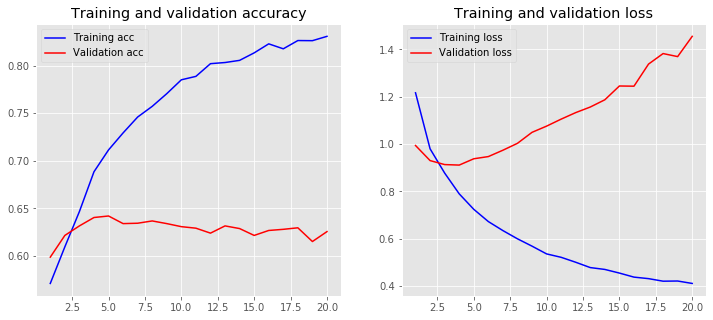

In [59]:
plot_history(nn_bow)

Alternative baseline model:https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [60]:
loss_trn, accuracy_trn = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_trn))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

Training Accuracy: 0.9237
Testing Accuracy:  0.6257


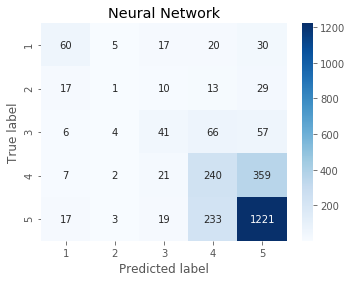

Training Accuracy: 0.9237
Testing Accuracy:  0.6257


In [61]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

predictions = model.predict(X_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("Neural Network")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

loss_trn, accuracy_trn = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_trn))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [62]:
from keras import backend as K

def recall_m(y_test, predictions):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predictions, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, predictions):
    precision = precision_m(y_test, predictions)
    recall = recall_m(y_test, predictions)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [63]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

2498/2498 [==============================] - 0s 112us/step
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       132
           1       0.07      0.01      0.02        70
           2       0.38      0.24      0.29       174
           3       0.42      0.38      0.40       629
           4       0.72      0.82      0.77      1493

    accuracy                           0.63      2498
   macro avg       0.43      0.38      0.40      2498
weighted avg       0.59      0.63      0.61      2498



In [64]:
y_test.argmax(axis = 1)

array([4, 4, 3, ..., 4, 4, 4], dtype=int64)

In [65]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

[5, 4, 5, 5]

In [66]:
test_indexes = sentences_test.index
# sample.iloc[test_indexes]
# sample.iloc[[5441],:]

In [67]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

# sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
846670,5.0,"Stunning talent. Great Musician, Beautiful artistry. Buy it, you won't be disappointed. XOXOXO","[stun, talent, great, musician, beautiful, artistry, buy, wo, nt, disappoint, xoxoxo]",5,0.0
1202437,5.0,"I,like many others, have only heard your music from watching episodes of ""Love and Hip Hop"".\n\n...","[i, like, many, others, hear, music, watch, episodes, love, hip, hop, your, voice, mesmerize, i,...",4,1.0
1453245,4.0,Great song.,"[great, song]",5,1.0
104862,4.0,Dead Again has a little of all of the elements of the great Type O albums as well as some old Ca...,"[dead, again, little, elements, great, type, o, albums, well, old, carnivore, manage, forge, new...",5,1.0
292071,5.0,"For the simple fact that I love Trey Songz voice , this was a good cd for me , however, R.Kelly ...","[for, simple, fact, i, love, trey, songz, voice, good, cd, however, rkelly, favorite, r, b, arti...",5,0.0
1553612,5.0,"One of his best tracks , back ground vocals any lyrics by Bjork original track production by Tre...","[one, best, track, back, grind, vocals, lyric, bjork, original, track, production, trent, reznor...",5,0.0
582501,5.0,Great tune,"[great, tune]",5,0.0
1535937,5.0,"Always been my favorite song. Make sure you have the amazon music app. to find this in you ""libr...","[always, favorite, song, make, sure, amazon, music, app, find, library]",5,0.0
826367,2.0,Love this CD but when it arrived the front of the CD case was cracked,"[love, cd, arrive, front, cd, case, crack]",5,3.0
1185445,5.0,I had an opportunity to hear this CD in a friends car a few weeks back. Track after track was gr...,"[i, opportunity, hear, cd, friends, car, weeks, back, track, track, great, i, ve, try, get, hand...",5,0.0


In [68]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1563
1.0     715
2.0     114
3.0      59
4.0      47
dtype: int64

## Word Embedding

There are 3 main ways to embed: 
1. Words represented by each word as a vector
2. Characters represented by each character as a vector
3. N-grams of words/characters represented as a vector (N-grams are overlapping groups of multiple succeeding words/characters in the text)

I will use method #1. Two ways to do this is via one-hot encoding and word embeddings.

### One-hot encoding

In [69]:
Y = sample['overall'].values
encoder = LabelEncoder()
encoder.fit(Y)
star_labels = encoder.fit_transform(Y)
star_labels

array([3, 4, 0, ..., 4, 4, 4])

In [70]:
from sklearn.preprocessing import OneHotEncoder

len_star = len(star_labels)

encoder = OneHotEncoder(sparse=False)
star_labels = star_labels.reshape((len_star, 1))
encoder.fit_transform(star_labels)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

### Using Word Embeddings

Use Keras' tokenizer to tokenize all words as numeric values. Using the num_words parameter does not have 

In [71]:
sentences_train.iloc[2]

'definitely upbeat inspirational song song encouragement rejoice always ways i highly recommend cd'

In [72]:
from keras.preprocessing.text import Tokenizer

# tokenizer = Tokenizer(num_words = None) #don't filter on top N most common words
tokenizer = Tokenizer(num_words = 5000) # filter on top 5000 most common words
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index)+1  #adding 1 because of reserved 0 index


print(sentences_train[776251]) #print sample review
print(X_train[2]) #print word indexing of sample reiew
len(X_train[2]) #count number of words in sample review

definitely upbeat inspirational song song encouragement rejoice always ways i highly recommend cd
[164, 337, 1863, 3, 3, 2697, 3369, 89, 933, 1, 259, 88, 17]


13

Find index of sample words

In [73]:
for word in ['good', 'bad', 'terrible']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

good: 13
bad: 142
terrible: 698


Find top 10 most frequent words

In [74]:
tokens_list = list(tokenizer.word_index)
tokens_list[0:10]

['i', 's', 'song', 'one', 'the', 'album', 'love', 'great', 'music', 'nt']

### Padding

In [75]:
maxlen = max([len(listElem.split()) for listElem in sentences]) ##find length of review with max number of words

In [76]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0:5, :])

[[ 134   13 1008 ...    0    0    0]
 [   1    7    9 ...    0    0    0]
 [ 164  337 1863 ...    0    0    0]
 [  14   89 1459 ...    0    0    0]
 [  12   62   21 ...    0    0    0]]


In [77]:
from keras.models import Sequential
from keras import layers
from keras import regularizers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(l=0.1)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3417, 50)          869950    
_________________________________________________________________
flatten_1 (Flatten)          (None, 170850)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1708510   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
Total params: 2,578,515
Trainable params: 2,578,515
Non-trainable params: 0
_________________________________________________________________


Check: https://github.com/tflearn/tflearn/issues/260

In [78]:
start_time = datetime.now()

nn_embed = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train



C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Duration: 0:07:30.426382


In [79]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')

joblib.dump(nn_embed, "nn_embed.pkl")

['nn_embed.pkl']

In [80]:
# os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')
# nn_embed = joblib.load("nn_embed.pkl")

In [81]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.5843
Testing Accuracy:  0.5977


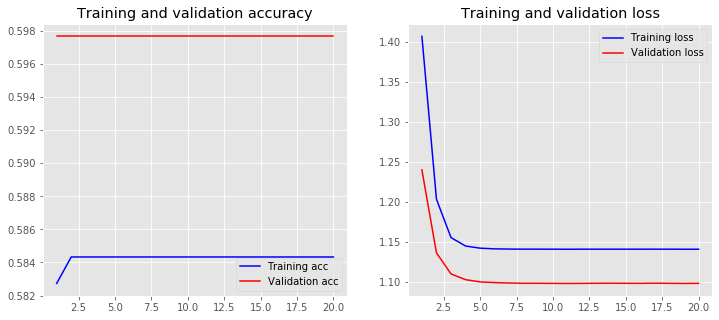

In [82]:
plot_history(nn_embed)

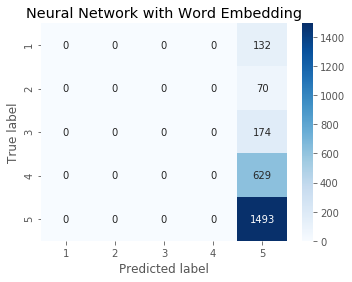

Training Accuracy: 0.5843
Testing Accuracy:  0.5977


In [83]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

predictions = model.predict(X_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("Neural Network with Word Embedding")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


In [84]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

2498/2498 [==============================] - 1s 201us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       132
           1       0.00      0.00      0.00        70
           2       0.00      0.00      0.00       174
           3       0.00      0.00      0.00       629
           4       0.60      1.00      0.75      1493

    accuracy                           0.60      2498
   macro avg       0.12      0.20      0.15      2498
weighted avg       0.36      0.60      0.45      2498



C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

[5, 5, 5, 5]

In [86]:
test_indexes = sentences_test.index
# sample.iloc[test_indexes]
# sample.iloc[[5441],:]

In [87]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
1093778,1.0,It was not REM. I deleted it.,"[it, rem, i, delete]",5,4.0
1133766,1.0,What a ripoff... charges same price as a full CD for one 20 minute.... I think NOT... sample sou...,"[what, ripoff, charge, price, full, cd, one, twenty, minute, i, think, not, sample, sound, medic...",5,4.0
13884,1.0,Could not get Amazon Cloud player to work after downloading their 'Amazon mp3 Downloader'... pai...,"[could, get, amazon, cloud, player, work, download, amazon, mp3, downloader, pay, five, mp3s, ob...",5,4.0
1136540,1.0,Didn't really work for me.,"[do, nt, really, work]",5,4.0
1458927,1.0,Did not. I could not install the app on my Lumia 950,"[do, i, could, install, app, lumia, nine hundred and fifty]",5,4.0
863992,1.0,DO NOT BUY THIS PRODUCT. Ive purchased two sets and Im returning them both because both sets ski...,"[do, not, buy, this, product, ive, purchase, two, set, im, return, set, skip, terribly, not, one...",5,4.0
920470,1.0,I wanted tool not a quartet,"[i, want, tool, quartet]",5,4.0
570964,1.0,"I heard this song on the radio and immediately fell in love with it.. However, the download MP3,...","[i, hear, song, radio, immediately, fell, love, it, however, download, mp3, constantly, skip, pl...",5,4.0
1048297,1.0,Not what I wanted,"[not, i, want]",5,4.0
848490,1.0,"This not a ""clean"" version. It says ""ass"" in the song. I cannot use this song for an exercise ...","[this, clean, version, it, say, ass, song, i, use, song, exercise, class]",5,4.0


In [88]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1493
1.0     629
2.0     174
3.0      70
4.0     132
dtype: int64

## CNN

In [89]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 2, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3417, 100)         1739900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3416, 128)         25728     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 55        
Total params: 1,766,973
Trainable params: 1,766,973
Non-trainable params: 0
_________________________________________________________________


In [90]:
start_time = datetime.now()

cnn_model = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train


C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Duration: 0:19:45.995882


In [91]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')

joblib.dump(cnn_model, "cnn_model.pkl")

['cnn_model.pkl']

In [92]:
# os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')

# cnn_model = joblib.load("cnn_model.pkl")

In [93]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9596
Testing Accuracy:  0.5548


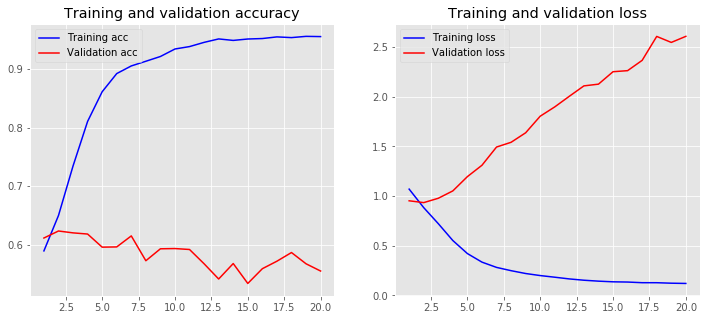

In [94]:
plot_history(cnn_model)

In [95]:
y_test[1]

array([0., 0., 0., 0., 1.], dtype=float32)

https://stackoverflow.com/questions/50920908/get-confusion-matrix-from-a-keras-multiclass-model

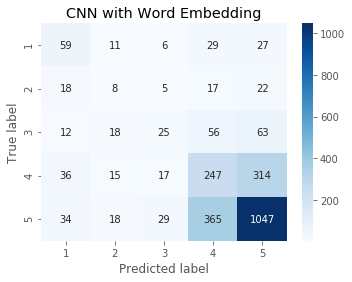

Training Accuracy: 0.9596
Testing Accuracy:  0.5548


In [96]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

predictions = model.predict(X_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("CNN with Word Embedding")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [97]:
from keras import backend as K

def recall_m(y_test, predictions):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predictions, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, predictions):
    precision = precision_m(y_test, predictions)
    recall = recall_m(y_test, predictions)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [98]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

2498/2498 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       0.37      0.45      0.41       132
           1       0.11      0.11      0.11        70
           2       0.30      0.14      0.20       174
           3       0.35      0.39      0.37       629
           4       0.71      0.70      0.71      1493

    accuracy                           0.55      2498
   macro avg       0.37      0.36      0.36      2498
weighted avg       0.56      0.55      0.55      2498



In [99]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

[5, 4, 5, 4]

In [100]:
test_indexes = sentences_test.index
# sample.iloc[test_indexes]
# sample.iloc[[5441],:]

In [101]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
589979,1.0,"My Alicia Keys - In Common mp3 song near the end, about the last 12 seconds stop cutting-off her...","[my, alicia, key, in, common, mp3, song, near, end, last, twelve, second, stop, cuttingoff, last...",5,4.0
1324045,1.0,to much background noise.,"[much, background, noise]",5,4.0
257854,5.0,If you give this album a try you will not be disappointed. Every song on Handguns is a treat to ...,"[if, give, album, try, disappoint, every, song, handguns, treat, listen]",1,4.0
1059294,1.0,This cd never make in cd only vinyl this is not original thanks,"[this, cd, never, make, cd, vinyl, original, thank]",5,4.0
884202,5.0,Whoever this guy was thinking of when he wrote this song is a very lucky woman:) Thank you Sons...,"[whoever, guy, think, write, song, lucky, woman, thank, sons, anarchy, play, guy, tune, show, th...",1,4.0
789345,5.0,Good music and I have played steel guitar behind this song many times and just didn't have a cop...,"[good, music, i, play, steel, guitar, behind, song, many, time, nt, copy]",1,4.0
774406,5.0,Great Song - but BEWARE - my card was stolen downloading from Amazon.,"[great, song, beware, card, steal, download, amazon]",1,4.0
1269703,1.0,there is weird drumming over this. Like some one over dubbed their drumming exercises.,"[weird, drum, like, one, dub, drum, exercise]",5,4.0
291933,5.0,After a long hiatus from the music industry Anita is back with a strong single from her cd that ...,"[after, long, hiatus, music, industry, anita, back, strong, single, cd, rapidly, climb, music, c...",1,4.0
1549974,5.0,\m/,[m],1,4.0


In [102]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1386
1.0     804
2.0     142
3.0     105
4.0      61
dtype: int64

## Pretrained GloVe Word Embedding

I created a function below to import and vectorize the word embedding that I had downloaded

In [103]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding = "utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [104]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\glove_6B')


embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)


82% of the words in my dataset vocabuluary is captured in the GloVe word embedding vector.

In [105]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8265417552732915

### Testing on Neural Network

In [106]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 3417, 50)          869950    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
Total params: 870,515
Trainable params: 870,515
Non-trainable params: 0
_________________________________________________________________


In [107]:
start_time = datetime.now()

nn_glove = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train


C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Duration: 0:04:43.237080


In [108]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')

joblib.dump(nn_glove, "nn_glove.pkl")

['nn_glove.pkl']

In [109]:
# os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')
# nn_glove = joblib.load("nn_glove.pkl")

In [110]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9370
Testing Accuracy:  0.5789


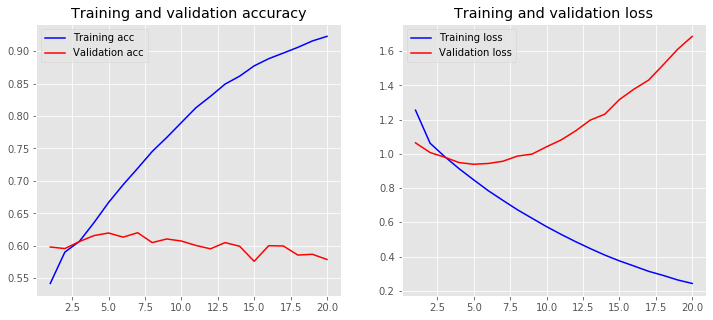

In [111]:
plot_history(nn_glove)

In [112]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
# y_pred = (predictions > 0.5)

# confusion_matrix(y_test, y_pred)

matrix = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1))
matrix

array([[  63,    7,   17,   25,   20],
       [  13,    4,   17,   15,   21],
       [  11,    6,   53,   54,   50],
       [  14,   11,   38,  253,  313],
       [  27,    8,   42,  343, 1073]], dtype=int64)

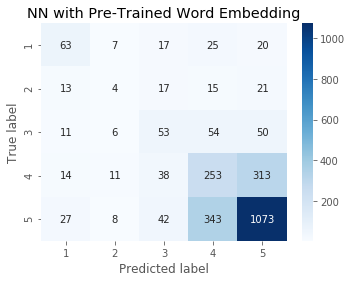

Training Accuracy: 0.9370
Testing Accuracy:  0.5789


In [113]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

predictions = model.predict(X_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("NN with Pre-Trained Word Embedding")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [114]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

2498/2498 [==============================] - 1s 236us/step
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       132
           1       0.11      0.06      0.08        70
           2       0.32      0.30      0.31       174
           3       0.37      0.40      0.38       629
           4       0.73      0.72      0.72      1493

    accuracy                           0.58      2498
   macro avg       0.40      0.39      0.40      2498
weighted avg       0.58      0.58      0.58      2498



In [115]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

[5, 5, 5, 3]

In [116]:
test_indexes = sentences_test.index
# sample.iloc[test_indexes]
# sample.iloc[[5441],:]

In [117]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
480155,5.0,"So Roger doesn't like Israel fine don't play , but wait Roger doesn't like the US wall and he is...","[so, roger, nt, like, israel, fine, nt, play, wait, roger, nt, like, us, wall, play, every, nook...",1,4.0
700903,5.0,I like being able to buy a single song over having to pay for an entire CD when only one on ther...,"[i, like, able, buy, single, song, pay, entire, cd, one, i, want, listen]",1,4.0
31582,1.0,YEAH SHES SO GOOD NO ONE WILL GIVE HER A RECORD DEAL...SHES SO GANGSTER SHE WANTED A TRUTH WITH ...,"[yeah, shes, so, good, no, one, will, give, her, a, record, deal, shes, so, gangster, she, want,...",5,4.0
1108753,5.0,"Full song, doesn't cut out, sounds like the original","[full, song, nt, cut, sound, like, original]",1,4.0
255144,1.0,All pretense and no real talent. If it was free I do not think I would take up the space or time...,"[all, pretense, real, talent, if, free, i, think, i, would, take, space, time, download, he, sam...",5,4.0
309180,5.0,"Lupe Fisaco He's Straight from the Chicago, Illinois and grewing up in the LBC, Drama was a Rapp...","[lupe, fisaco, he, s, straight, chicago, illinois, grewing, lbc, drama, rapper, he, s, such, a, ...",1,4.0
247608,1.0,"you have to buy this 2 cd set,\nthere is only 1 other song on this 2 cd set that is good, but it...","[buy, two, cd, set, one, song, two, cd, set, good, old, song, another, releaselooks, like, hear,...",5,4.0
1575141,5.0,"The album was a pleasant surprise, I'm upset I didn't listen to it sooner. De La manages to stay...","[the, album, pleasant, surprise, i, m, upset, i, nt, listen, sooner, de, la, manage, stay, true,...",1,4.0
76619,5.0,"Found this song, thought it was the real deal but it was a cover. Searched for, and found, the ...","[find, song, think, real, deal, cover, search, find, original, thirty, cents, waste, ninety-nine...",1,4.0
520559,1.0,The collection is fantastic. But $130 per record is a Diddy Wah Diddy...,"[the, collection, fantastic, but, one hundred and thirty, per, record, diddy, wah, diddy]",5,4.0


In [118]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1446
1.0     791
2.0     146
3.0      68
4.0      47
dtype: int64

### CNN with Pre-trained GloVe Embedding

In [119]:
from keras import optimizers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen,
                          weights = [embedding_matrix],
                          trainable = True))
model.add(layers.Conv1D(128, 5, activation= 'softmax'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))
optimizer = optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer = 'adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 3417, 50)          869950    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3413, 128)         32128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 15)                1935      
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 80        
Total params: 904,093
Trainable params: 904,093
Non-trainable params: 0
________________________________________________

In [120]:
start_time = datetime.now()

cnn_glove = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train


C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Duration: 0:29:01.743509


In [121]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')

joblib.dump(cnn_glove, "cnn_glove.pkl")

['cnn_glove.pkl']

In [122]:
# os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')
# cnn_glove = joblib.load("cnn_bow.pkl")

In [123]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9429
Testing Accuracy:  0.5905


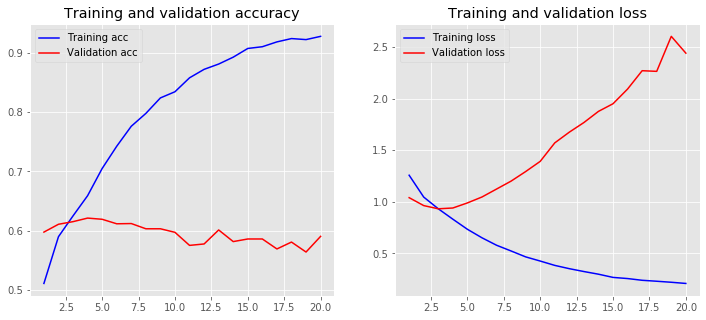

In [124]:
plot_history(cnn_glove)

In [125]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
# y_pred = (predictions > 0.5)

# confusion_matrix(y_test, y_pred)

matrix = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1))
matrix

array([[  48,    8,   35,   18,   23],
       [  13,    5,   21,    9,   22],
       [   8,    5,   50,   45,   66],
       [   9,    3,   61,  152,  404],
       [  19,    2,   59,  193, 1220]], dtype=int64)

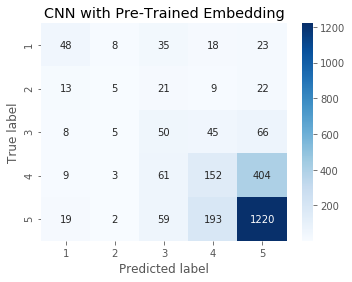

Training Accuracy: 0.9429
Testing Accuracy:  0.5905


In [126]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

predictions = model.predict(X_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("CNN with Pre-Trained Embedding")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [127]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

2498/2498 [==============================] - 6s 2ms/step
              precision    recall  f1-score   support

           0       0.49      0.36      0.42       132
           1       0.22      0.07      0.11        70
           2       0.22      0.29      0.25       174
           3       0.36      0.24      0.29       629
           4       0.70      0.82      0.76      1493

    accuracy                           0.59      2498
   macro avg       0.40      0.36      0.36      2498
weighted avg       0.56      0.59      0.57      2498



In [128]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

[5, 5, 5, 5]

In [129]:
test_indexes = sentences_test.index
# sample.iloc[test_indexes]
# sample.iloc[[5441],:]

In [130]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
920470,1.0,I wanted tool not a quartet,"[i, want, tool, quartet]",5,4.0
704653,5.0,"I have seen Will Downing in concert several times, and each time he never disappoints!! When he ...","[i, see, will, down, concert, several, time, time, never, disappoint, when, perform, song, do, n...",1,4.0
753912,1.0,I did not purchase this??,"[i, purchase]",5,4.0
800466,1.0,Can download song,"[can, download, song]",5,4.0
1059294,1.0,This cd never make in cd only vinyl this is not original thanks,"[this, cd, never, make, cd, vinyl, original, thank]",5,4.0
1108753,5.0,"Full song, doesn't cut out, sounds like the original","[full, song, nt, cut, sound, like, original]",1,4.0
520559,1.0,The collection is fantastic. But $130 per record is a Diddy Wah Diddy...,"[the, collection, fantastic, but, one hundred and thirty, per, record, diddy, wah, diddy]",5,4.0
102267,5.0,"She was, like Chet Atkins, a Nashville star that could perform in any venue.\nAn appalling decis...","[she, like, chet, atkins, nashville, star, could, perform, venue, an, appal, decision, manager, ...",1,4.0
1136540,1.0,Didn't really work for me.,"[do, nt, really, work]",5,4.0
1269703,1.0,there is weird drumming over this. Like some one over dubbed their drumming exercises.,"[weird, drum, like, one, dub, drum, exercise]",5,4.0


In [131]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1475
1.0     750
2.0     180
3.0      51
4.0      42
dtype: int64

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

## Hyperparamaterization

Below, I used the GridSeach method for testing out various parameter combinations that would optimized performance. To limit the time needed for training on all parameter combinations, gridsearch was only performed on a sample dataset of 1000 records. The code below was tested in a separate notebook with a smaller dataframe sample size. The parameters I chose in my CNN model above were based on the results from the GridSearch

First, I set the parameter values I wanted to test

In [ ]:
learning_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.2, 0.4, 0.6]
activation = ['relu', 'softmax']
neurons = [2, 5, 10, 15]

Then, I created a function that tests for each of these specified parameters, and printed out the optimal combination. I ended up choosing the 

In [ ]:
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier


start_time = datetime.now()

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# Create the parameter grid based on the results of random search 
    
param_grid = {
    'learning_rate': learning_rate,
    'dropout_rate': dropout_rate,
    'activation': activation,
    'neurons': neurons
}


def create_model(dropout_rate = 0.0, learning_rate = 0, neurons = 2, activation = 'relu'):
    embedding_dim = 50

    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen,
                              weights = [embedding_matrix],
                              trainable = True))
    model.add(layers.Conv1D(128, 5, activation= 'relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(5, activation='softmax'))
    optimizer = optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = 'adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
#     model.summary()
    return model

seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn= create_model, epochs = 5, batch_size = 10, verbose = 0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3 
#                            n_jobs = -1
                          )


grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train

I then created a dataframe of all the gridsearch results. I ended up choosing the parameter combination with one of the highest mean scores from cross-fold validation, and also the smalled standard deviation of accuracy.

In [ ]:
result_mean_scores = grid_result.cv_results_['mean_test_score']
result_std_scores = grid_result.cv_results_['std_test_score']
result_params = grid_result.cv_results_['params']
grid_results_df = pd.DataFrame(zip(result_params, result_mean_scores, result_std_scores), columns = ['Params', 'Mean_Score', 'Std_Score'])
grid_results_df.sort_values(by = ['Mean_Score'], ascending = False).head(20).reset_index(drop = True)

In [ ]:
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
X_test